# Part 1
First we load the data and inspect the login data. After we will aggregate these login counts based on 15minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand.

In [402]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
import json


In [404]:
file = 'logins.json'
f = open(file)
logins = json.loads(f.read())

In [406]:
logins.keys()

dict_keys(['login_time'])

In [408]:
print(len(logins['login_time']))

93142


In [410]:
logins = pd.DataFrame(pd.to_datetime(logins['login_time']), columns = ['login_time'])

In [412]:
logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [414]:
logins.dtypes

login_time    datetime64[ns]
dtype: object

In [416]:
logins.isna().sum()

login_time    0
dtype: int64

In [418]:
logins['login_count'] = 1
logins.index = logins['login_time']
logins.drop('login_time', axis = 1, inplace = True)
logins.head()

,login_count
login_time,
1970-01-01 20:13:18,1
1970-01-01 20:16:10,1
1970-01-01 20:16:37,1
1970-01-01 20:16:36,1
1970-01-01 20:26:21,1


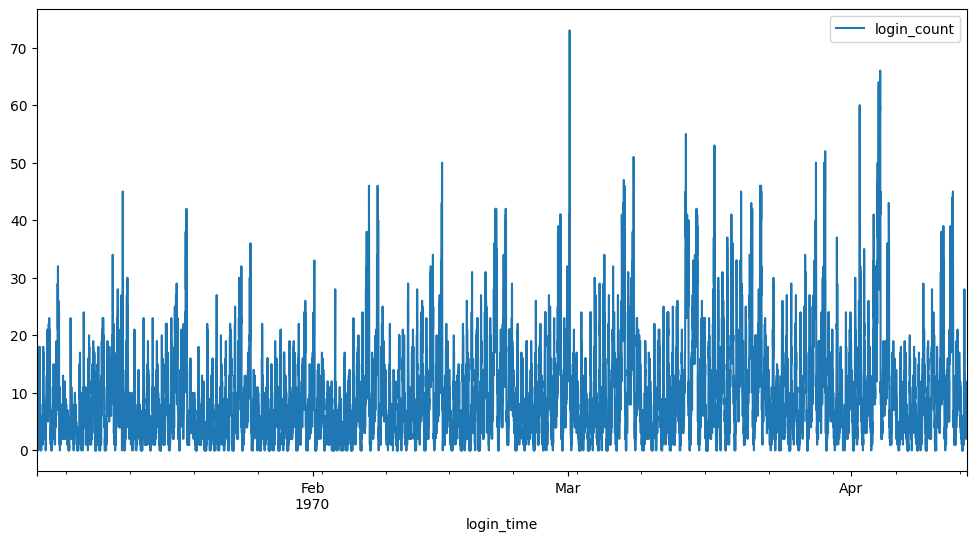

In [431]:
logins = logins.resample('15min').sum()
logins.plot(kind = 'line', figsize = (12,6))
plt.show()

After plotting we can conclude that trip demand has been increasing since february, and that trips tend to have a 12 h rythm. Further it seems like the day of the week is an important factor and needs further investigation.

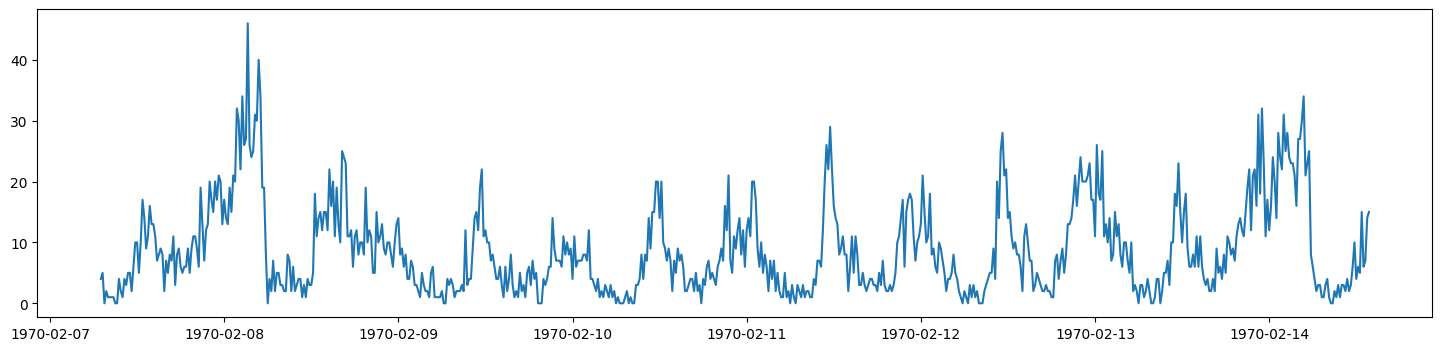

In [434]:
plt.figure(figsize = (18,4))
plt.plot(logins[3500:4200])
plt.show()

In [436]:
logins.describe()

,login_count
count,9788.000000
mean,9.515938
std,8.328818
min,0.000000
25%,3.000000
50%,7.000000
75%,13.000000
max,73.000000


The average count of logins per 15 min is 7. How are these logins distributed?

In [438]:
logins = logins.assign(month_day = logins.index.day)
logins = logins.assign(weekday = logins.index.weekday)

In [214]:
logins.head()

,login_count,month_day,weekday
login_time,,,
1970-01-01 20:00:00,2,1,3
1970-01-01 20:15:00,6,1,3
1970-01-01 20:30:00,9,1,3
1970-01-01 20:45:00,7,1,3
1970-01-01 21:00:00,1,1,3


In [216]:
spike = np.quantile(logins,0.99)
spikes = logins[logins['login_count'] >= spike]
month_days = []
weekdays = []
for date in spikes.index:
    month_days.append(date.day)
    weekdays.append(date.weekday())

spike_days = pd.DataFrame(month_days, columns = ['day'], index = range(len(month_days)))
spike_weekdays = pd.DataFrame(weekdays, columns = ['weekday'], index = range(len(weekdays)))

In [218]:
spike_days.value_counts()

day
21     25
4      24
15     18
22     18
28     17
7      15
8      15
14     14
29     14
3      13
12     13
1      11
13     11
18     10
11     10
19      9
6       9
27      8
5       8
17      7
2       4
20      4
10      4
25      2
16      1
24      1
30      1
Name: count, dtype: int64

In [220]:
spike_weekdays.value_counts()

weekday
5          104
6          103
4           48
3           15
1            7
2            7
0            2
Name: count, dtype: int64

What we can see from this analysis is that demand seems to be much more on the weekends, which makes sense as people are going out and are not working. Let's use some plotting to understand this data better.

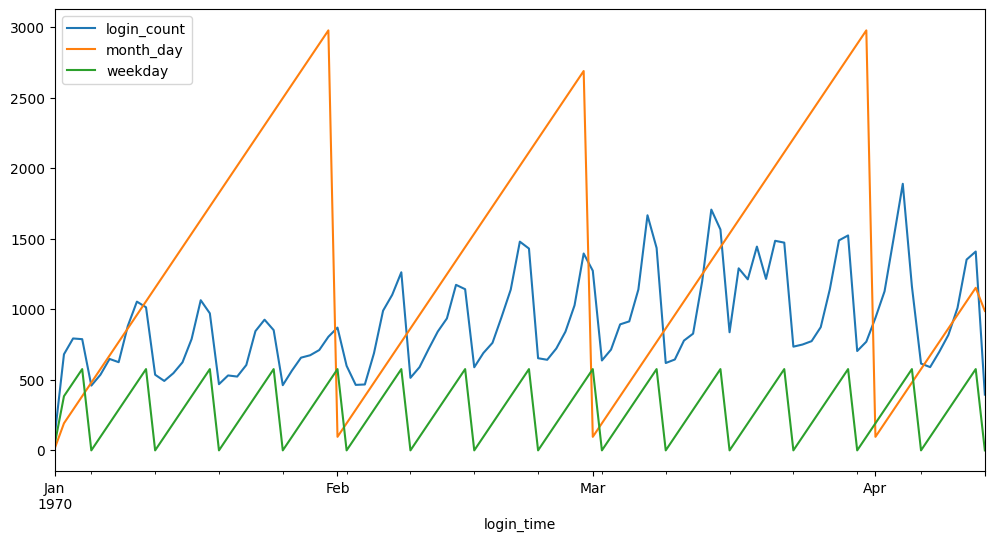

In [442]:
daily_freq = logins.resample('1D').sum()
daily_freq.plot(kind = "line", figsize =(12,6))
plt.show()

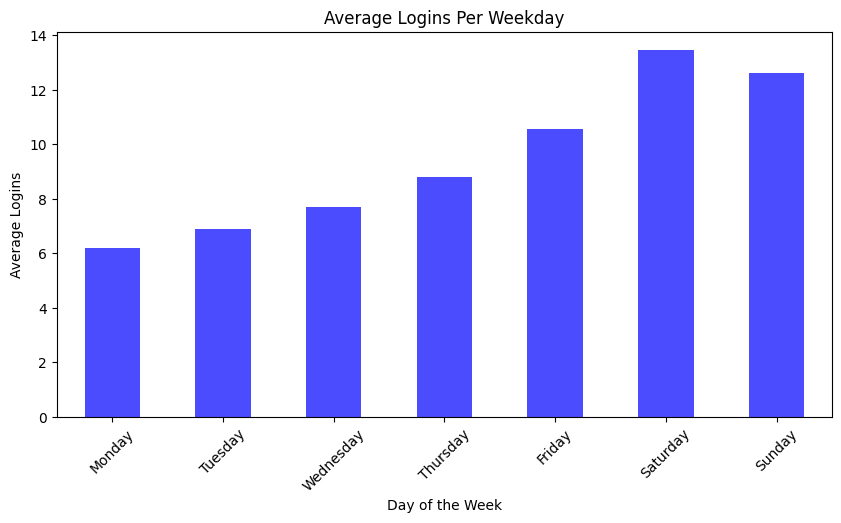

In [446]:
import matplotlib.pyplot as plt

# Group by weekday and compute the average logins
logins['weekday'] = logins.index.day_name()
weekly_trend = logins.groupby('weekday')['login_count'].mean()

# Sort by actual weekday order
ordered_days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
weekly_trend = weekly_trend.reindex(ordered_days)

# Plot
plt.figure(figsize=(10,5))
weekly_trend.plot(kind='bar', color='blue', alpha=0.7)
plt.xlabel("Day of the Week")
plt.ylabel("Average Logins")
plt.title("Average Logins Per Weekday")
plt.xticks(rotation=45)
plt.show()

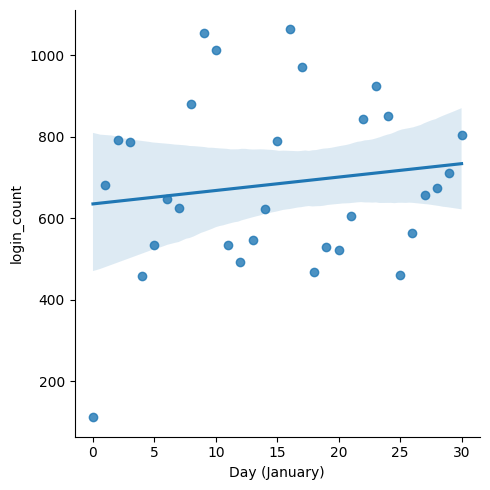

In [448]:
plot_trend = daily_freq[daily_freq.index.month==1]
plot_trend = plot_trend.assign(x=range(plot_trend.shape[0]))
sns.lmplot(data= plot_trend, x='x', y= 'login_count')
plt.xlabel('Day (January)')
plt.ylabel('login_count')
plt.show()

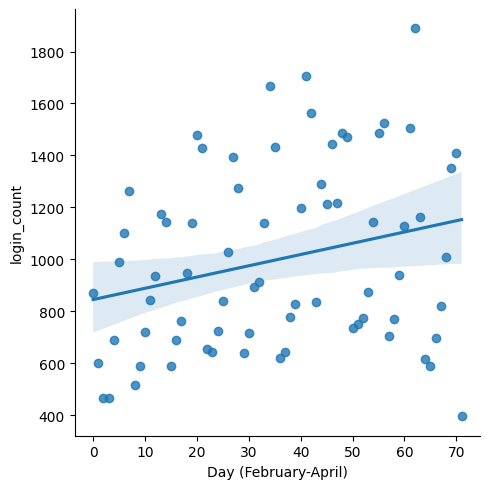

In [450]:
plot_trend = daily_freq[daily_freq.index.month!=1]
plot_trend = plot_trend.assign(x=range(plot_trend.shape[0]))
sns.lmplot(data= plot_trend, x='x', y= 'login_count')
plt.xlabel('Day (February-April)')
plt.ylabel('login_count')
plt.show()

The increase in demand has been happening since February and is continuing.

# Part 2 see pdf

# Part 3

The idea behind the target variable will be if a user is active or not within the last 30 days. Active users can show more distinct behaviour patterns that can help companies tailor promotions for increase in usage and behaviour patterns. For this we will set up a Random Forest and and XGBoost model and compare their results.

In [273]:
file = 'ultimate_data_challenge.json'
with open(file) as f:
    data = json.loads(f.read())
df = pd.DataFrame(data)
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [275]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [277]:
df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


In [281]:
tripcount = df['trips_in_first_30_days'].value_counts(normalize=True)*100
tripcount.head(7)

trips_in_first_30_days
0    30.780
1    28.216
2    14.804
3     7.576
4     5.124
5     3.232
6     2.268
Name: proportion, dtype: float64

In [287]:
np.sum(tripcount[1:])

69.22

In [289]:
df = df.drop(df[df.phone.isna()==True].index,axis = 0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49604 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    49604 non-null  object 
 1   trips_in_first_30_days  49604 non-null  int64  
 2   signup_date             49604 non-null  object 
 3   avg_rating_of_driver    41578 non-null  float64
 4   avg_surge               49604 non-null  float64
 5   last_trip_date          49604 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               49604 non-null  float64
 8   ultimate_black_user     49604 non-null  bool   
 9   weekday_pct             49604 non-null  float64
 10  avg_dist                49604 non-null  float64
 11  avg_rating_by_driver    49406 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.6+ MB


In [291]:
df['avg_rating_of_driver'].describe()

count    41578.000000
mean         4.601467
std          0.617377
min          1.000000
25%          4.300000
50%          4.900000
75%          5.000000
max          5.000000
Name: avg_rating_of_driver, dtype: float64

In [295]:
df['avg_rating_by_driver'].describe()

count    49406.000000
mean         4.777861
std          0.447114
min          1.000000
25%          4.700000
50%          5.000000
75%          5.000000
max          5.000000
Name: avg_rating_by_driver, dtype: float64

In [297]:
fill_val = (4.777861+5) / 2
df['avg_rating_by_driver'] = df['avg_rating_by_driver'].fillna(value=fill_val)
df['avg_rating_of_driver'] = df['avg_rating_of_driver'].fillna(value=4.9)

In [299]:
print(df.isnull().sum())

city                      0
trips_in_first_30_days    0
signup_date               0
avg_rating_of_driver      0
avg_surge                 0
last_trip_date            0
phone                     0
surge_pct                 0
ultimate_black_user       0
weekday_pct               0
avg_dist                  0
avg_rating_by_driver      0
dtype: int64


In [311]:
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])
current_date = df['last_trip_date'].max()
df['active'] = df['last_trip_date'].apply(lambda date: 0 if (current_date-date).days>30 else 1)
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,0


Only 37.6% of users remain active by the end of the six-month period. To understand the key factors influencing user activity, we will develop a predictive model. Given that the dataset has relatively few features, dimensionality reduction techniques like PCA are unnecessary.

In [313]:
df['active'].value_counts()

active
0    30933
1    18671
Name: count, dtype: int64

In [315]:
features = pd.get_dummies(df,columns =['city', 'phone', 'ultimate_black_user'])
features.head()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,active,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,ultimate_black_user_False,ultimate_black_user_True
0,4,2014-01-25,4.7,1.10,2014-06-17,15.4,46.2,3.67,5.0,1,False,True,False,False,True,False,True
1,0,2014-01-29,5.0,1.00,2014-05-05,0.0,50.0,8.26,5.0,0,True,False,False,True,False,True,False
2,3,2014-01-06,4.3,1.00,2014-01-07,0.0,100.0,0.77,5.0,0,True,False,False,False,True,True,False
3,9,2014-01-10,4.6,1.14,2014-06-29,20.0,80.0,2.36,4.9,1,False,True,False,False,True,False,True
4,14,2014-01-27,4.4,1.19,2014-03-15,11.8,82.4,3.13,4.9,0,False,False,True,True,False,True,False


In [317]:
target = features['active']
features = features.drop(['last_trip_date', 'signup_date', 'active'], axis =1)

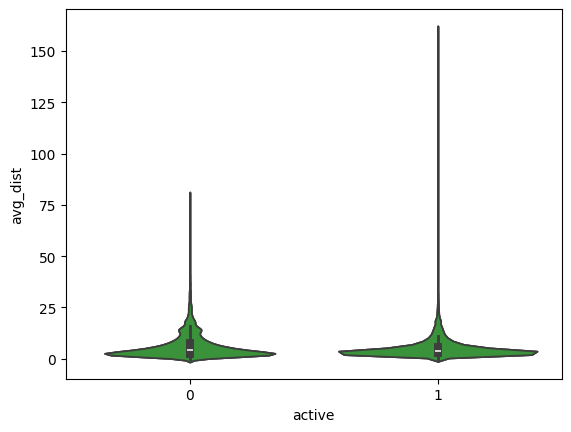

In [323]:
sns.violinplot(data = df, x ='active', y='avg_dist')
plt.show()

In [325]:
pd.pivot_table(df,index='active',aggfunc={'avg_dist':['mean','std']})

avg_dist          
            mean       std
active                    
0       6.190725  6.184010
1       5.113930  4.617779

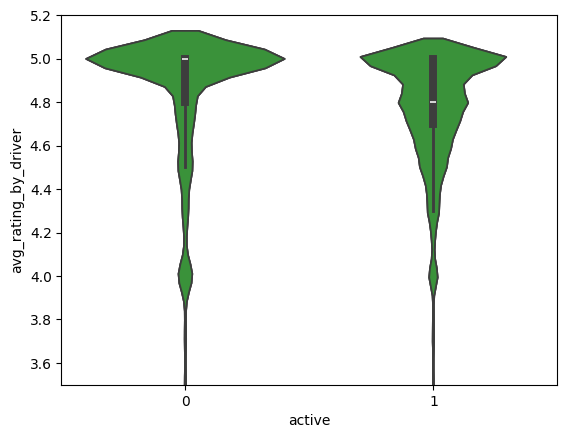

In [331]:
sns.violinplot(data =df, x='active', y='avg_rating_by_driver')
plt.ylim([3.5,5.2])
plt.show()


In [333]:
pd.pivot_table(df,index='active',aggfunc={'avg_rating_by_driver':['median','std']})

avg_rating_by_driver          
                     median       std
active                               
0                       5.0  0.503901
1                       4.8  0.328753

In [335]:
pd.pivot_table(df,index='active',aggfunc={'trips_in_first_30_days':['mean','std']})

trips_in_first_30_days          
                         mean       std
active                                 
0                    1.657033  2.655767
1                    3.304804  4.985057

Active users took more trips in their first 30 days. That is a useful trend for the predictive model.

In [337]:
df.active.value_counts(normalize = True)*100

active
0    62.35989
1    37.64011
Name: proportion, dtype: float64

# Random Forest and XGBoost

In [459]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from sklearn.linear_model import LogisticRegression

In [461]:
scaler = QuantileTransformer()
scaled_features = scaler.fit_transform(features)

In [463]:
X_train, X_test, y_train, y_test = train_test_split(scaled_features, target, test_size=0.2,random_state=42)

In [347]:
rf = RandomForestClassifier(n_estimators=1000)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)

In [349]:
rf.score(X_test,y_test)

0.7495212176191917

In [351]:
print(cross_val_score(rf,X_test,np.ravel(y_test),cv=5))
print('Mean Cross Validated Score:',np.mean(cross_val_score(rf,X_test,np.ravel(y_test),cv=5)))

[0.75717884 0.74747984 0.75       0.74899194 0.74445565]
Mean Cross Validated Score: 0.7474039164703015


In [354]:
df_importance = pd.DataFrame(zip(list(features.columns),rf.feature_importances_),index=range(features.columns.shape[0]),columns=['feature','importance'])
df_importance.sort_values(by='importance',ascending=False)

,feature,importance
5,avg_dist,0.300680
4,weekday_pct,0.131927
6,avg_rating_by_driver,0.112730
0,trips_in_first_30_days,0.081328
1,avg_rating_of_driver,0.080855
3,surge_pct,0.078995
2,avg_surge,0.067738
8,city_King's Landing,0.046731
11,phone_iPhone,0.020116
10,phone_Android,0.019203


average distance driven, weekday percentage, and the rating given to the passenger by the driver seem to be important features.

In [356]:
precision_recall_fscore_support(y_test,y_pred)

(array([0.8000323 , 0.66568365]),
 array([0.79887097, 0.66729374]),
 array([0.79945121, 0.66648772]),
 array([6200, 3721]))

In [358]:
precision_recall_fscore_support(y_test,y_pred,average='weighted')

(0.7496430942374374, 0.7495212176191917, 0.7495815276410341, None)

In [360]:
confusion_matrix(y_test,y_pred)

array([[4953, 1247],
       [1238, 2483]])

75% for the Random Forest Model is a good start. For the purpose of this challenge another model is used. Both models are not using any hyperparamter tuning yet as we want to first compare their performance with each other.

In [364]:
import xgboost as xgb
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [374]:
# Initialize XGBoost Classifier
xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',  # Use 'multi:softmax' for multi-class classification
    eval_metric='logloss',        # Use 'mlogloss' for multi-class
    n_estimators=100,  # Number of trees
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Train the model
xgb_clf.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [376]:
y_pred = xgb_clf.predict(X_test)


In [378]:
from sklearn.metrics import accuracy_score, classification_report
# Accuracy Score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.7905
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.86      0.84      6200
           1       0.74      0.67      0.71      3721

    accuracy                           0.79      9921
   macro avg       0.78      0.77      0.77      9921
weighted avg       0.79      0.79      0.79      9921



Using the XGBoost Model has increased the accuracy of our model to 79%. While ther is room for improvement this is a promising start.

# Model Comparison

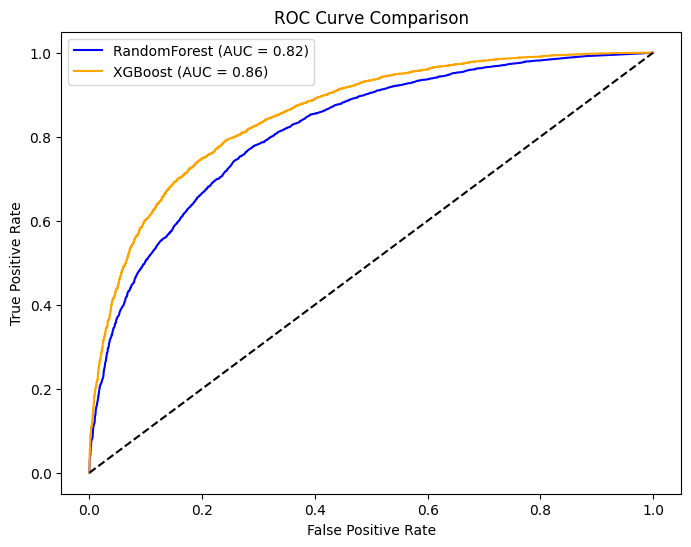

In [384]:
from sklearn.metrics import roc_curve, auc

# Compute probabilities
rf_probs = rf.predict_proba(X_test)[:, 1]
xgb_probs = xgb_clf.predict_proba(X_test)[:, 1]

# Compute ROC curve
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_probs)

# Compute AUC score
rf_auc = auc(rf_fpr, rf_tpr)
xgb_auc = auc(xgb_fpr, xgb_tpr)

# Plot ROC Curve
plt.figure(figsize=(8,6))
plt.plot(rf_fpr, rf_tpr, label=f'RandomForest (AUC = {rf_auc:.2f})', color='blue')
plt.plot(xgb_fpr, xgb_tpr, label=f'XGBoost (AUC = {xgb_auc:.2f})', color='orange')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()

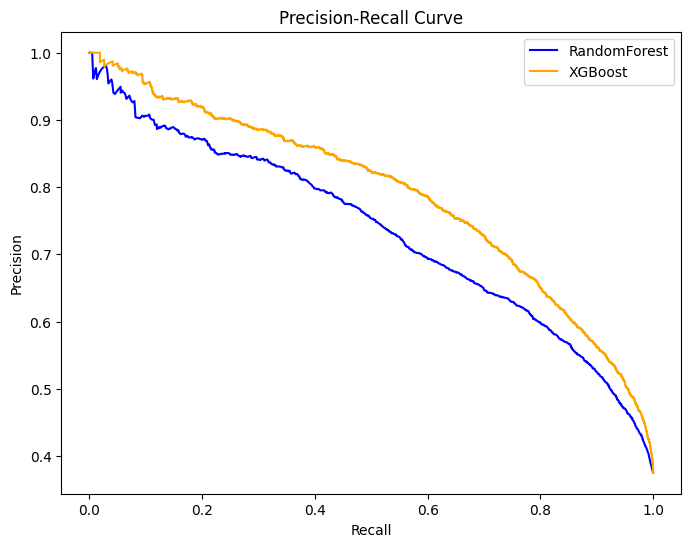

In [388]:
from sklearn.metrics import precision_recall_curve

# Compute precision-recall curve
rf_precision, rf_recall, _ = precision_recall_curve(y_test, rf_probs)
xgb_precision, xgb_recall, _ = precision_recall_curve(y_test, xgb_probs)

# Plot Precision-Recall Curve
plt.figure(figsize=(8,6))
plt.plot(rf_recall, rf_precision, label='RandomForest', color='blue')
plt.plot(xgb_recall, xgb_precision, label='XGBoost', color='orange')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

We can see that overall the XGBoost model seems to be a better fit for further work!

## Conclusion:

Trips in the first 30 days: As the number of trips in the first 30 days increases, so does the chance that a rider is active after 6 months.

Based on these insights gained from the model, there are several recomendations for the company.

- Offer incentives to riders to use the app on the weekends
- Incentivize riders to take more trips during their first 30 days on the app
- Encourage drivers not to artificially inflate the ratings they give to users, especially if the driver can tell that they've never done this before.
- Alternitavely, find ways to boost rides during the weekday
- 
Following these guidelines will increase the chances of more active users in the long term, and therefore more revenue for the company.